# Implémentation du schéma de Rusanov

In [8]:
# Importations
import math as math
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation

Déclaration des différents paramètres du problème :

In [9]:
g=1 # Constante gravitationnelle
N=64
h=1/(N+1) # Pas du maillage spatial
T=1 # Temps Max
t=0 # Temps dans la simulation
n=0 # Nombre d'itérations

X = np.linspace(0, 1, N+2) # Discrétisation de [0, 1]

# Tableau avec 2 lignes et N colonnes : discrétisation du vecteur (h, q) en N parties
# On commence avec h = q = 1 sur tout l'ensemble étudié :

U = np.ones((2,N+2))
Uprime = np.zeros((2,N+2)) # Pour faire les calculs dans la boucle
U[1,:] = np.exp(-(X)) # Debit initial

Code pour permettre la sauvegarde d'un nombre déterminé d'étapes (pour ne pas enregistrer toutes les étapes) :

In [10]:
nSauvegarde=100
j=0
tSauvegarde=[False for i in range(nSauvegarde)]

Fonctions qui vont permettre de faire l'affichage ou la sauvegarde de la solution :

In [11]:
def affiche_U():
    
    X = [h*i for i in range(N+2)]
    fig, axs = plt.subplots(1,2)
    
    axs[0].plot(X,U[0,:])
    axs[0].set_title("h")
    axs[0].set_ylim([0,1.5])
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q")
    axs[1].set_ylim([0,1.5])
    
    plt.show()

def enregistre_U(n,t):

    t=round(t,4) # Troncature de t après la 4eme décimale
    
    fig, axs = plt.subplots(1,2)
    fig.suptitle("t="+str(t),fontsize=16)

    axs[0].plot(X,U[0,:])
    axs[0].set_title("h")
    axs[0].set_ylim([0,1.5])
    
    axs[1].plot(X,U[1,:])
    axs[1].set_title("q")
    axs[1].set_ylim([0,1.5])
    
    plt.savefig("etape"+str(n)+".png")
    
    plt.close()

Fonction qui intervient dans le schéma :

In [12]:
def fonctionF(U,i,tau):
    F=[]
    F.append( U[1,i+1] - U[1,i-1] )
    F.append( ( U[1,i+1]**2 ) / U[0,i+1] + (g*U[0,i+1]**2) / 2 - ( U[1,i-1]**2 ) / U[0,i-1] - (g*U[0,i-1]**2) / 2)
    F[0] *= (tau/(2*h))
    F[1] *= (tau/(2*h))
    return(F)

Résolution :

t=0


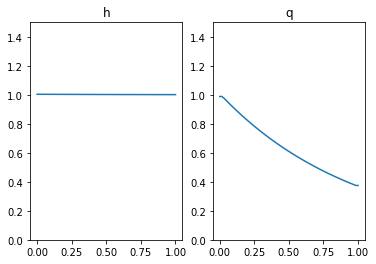

t=0.0039
t=0.0077


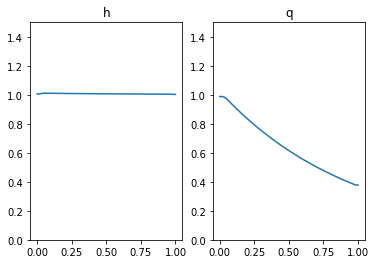

t=0.0116
t=0.0155
t=0.0194


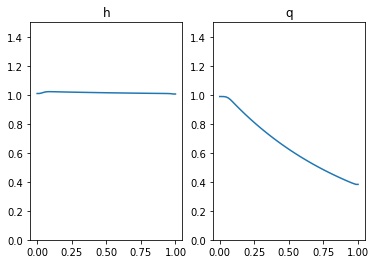

t=0.0232
t=0.0271


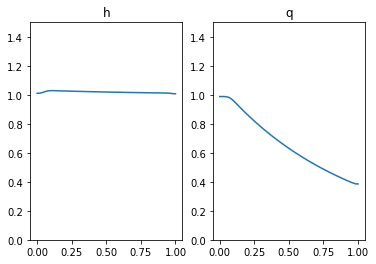

t=0.031
t=0.0349
t=0.0388


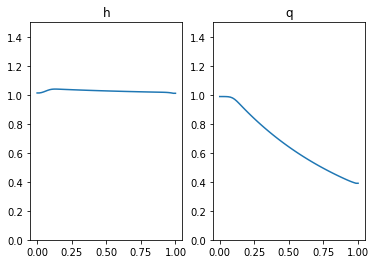

t=0.0426
t=0.0465


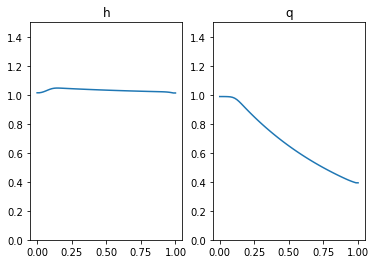

t=0.0504
t=0.0543
t=0.0582


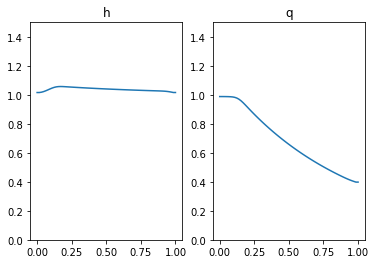

t=0.0621
t=0.0659
t=0.0698


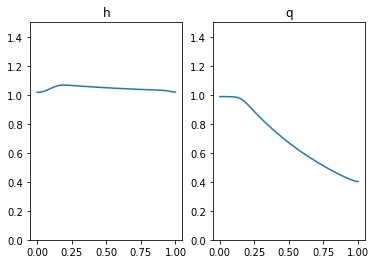

t=0.0737
t=0.0776


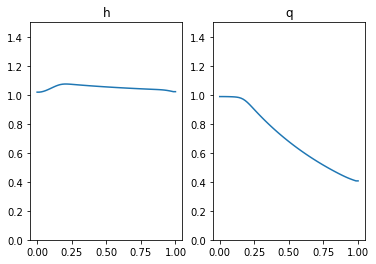

t=0.0815
t=0.0854
t=0.0893


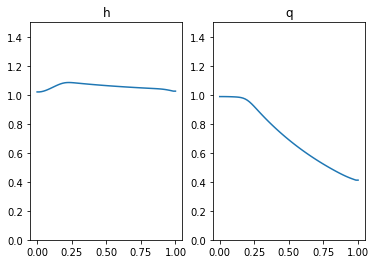

t=0.0931
t=0.097


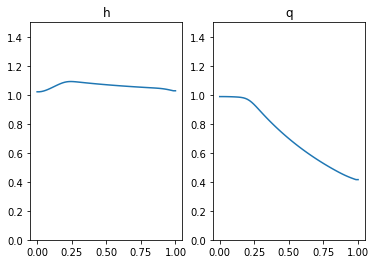

t=0.1009
t=0.1048
t=0.1087


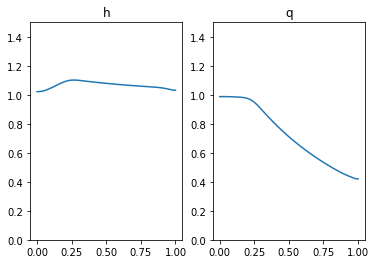

t=0.1126
t=0.1165


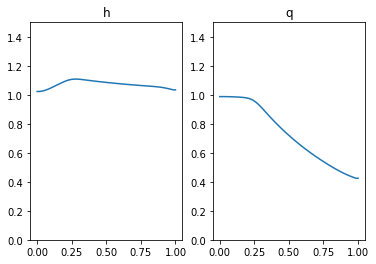

t=0.1204
t=0.1243
t=0.1281


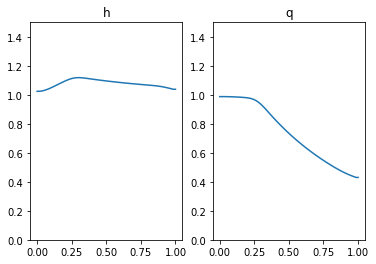

t=0.132
t=0.1359
t=0.1398


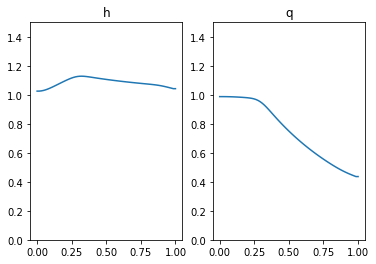

t=0.1437
t=0.1476


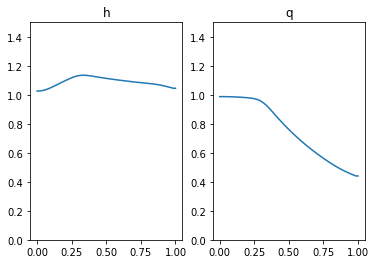

t=0.1515
t=0.1554
t=0.1593


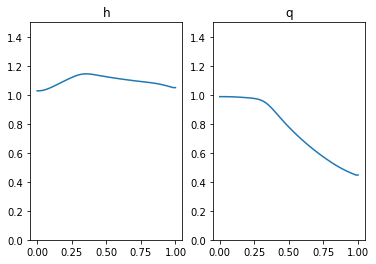

t=0.1632
t=0.1671


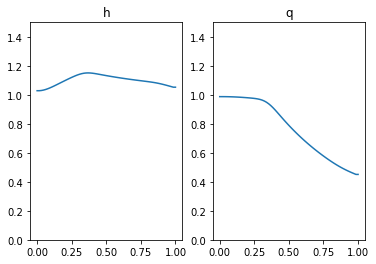

t=0.171
t=0.1749
t=0.1788


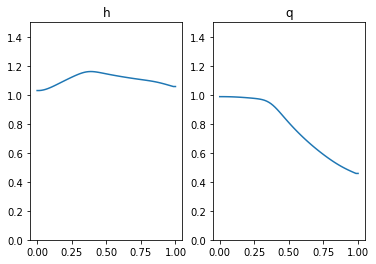

t=0.1827
t=0.1866


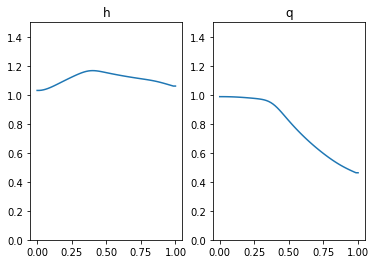

t=0.1905
t=0.1944
t=0.1983


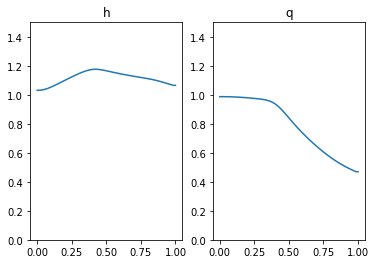

t=0.2022
t=0.2061
t=0.21


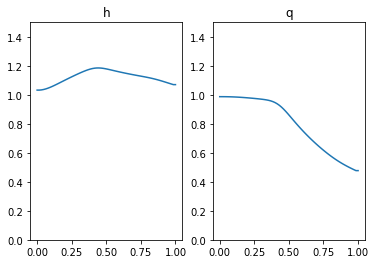

t=0.2139
t=0.2178


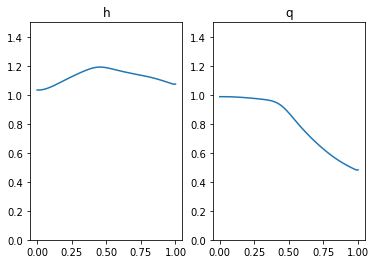

t=0.2217
t=0.2256
t=0.2295


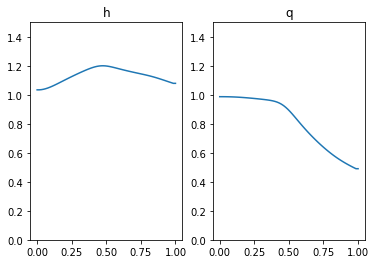

t=0.2334
t=0.2373


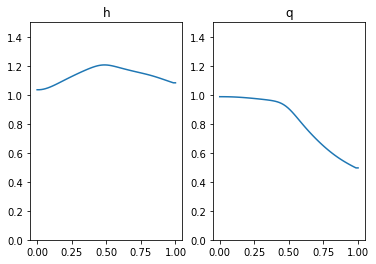

t=0.2412
t=0.2451
t=0.249


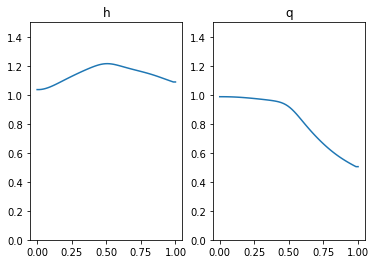

t=0.2529
t=0.2568


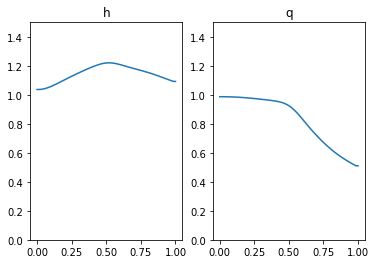

t=0.2607
t=0.2646
t=0.2685


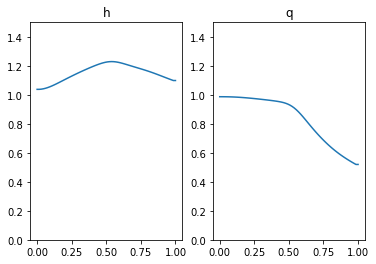

t=0.2724
t=0.2763


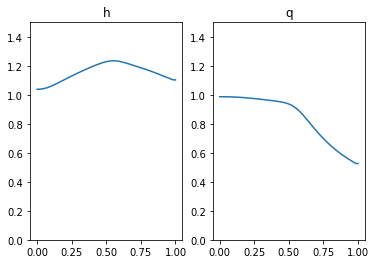

t=0.2802
t=0.2841
t=0.288


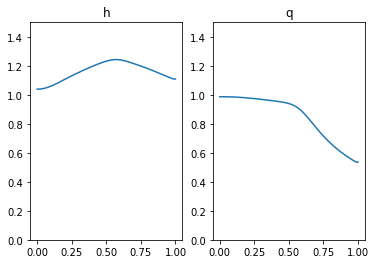

t=0.2919
t=0.2958
t=0.2997


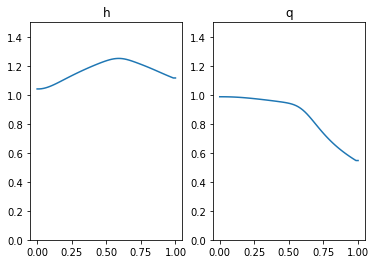

t=0.3036
t=0.3076


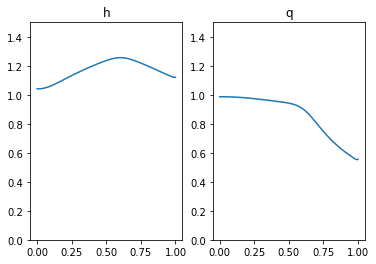

t=0.3115
t=0.3154
t=0.3193


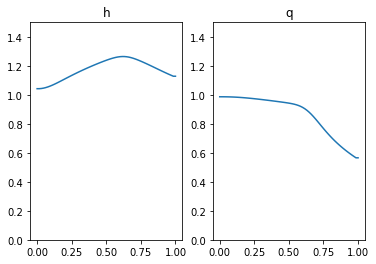

t=0.3232
t=0.3271


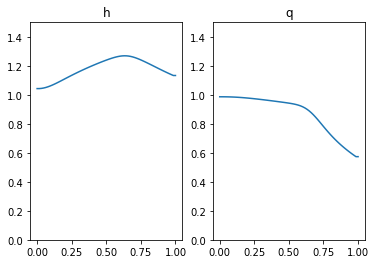

t=0.331
t=0.3349
t=0.3388


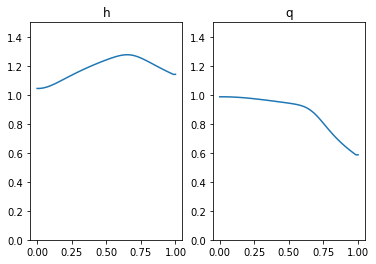

t=0.3427
t=0.3467


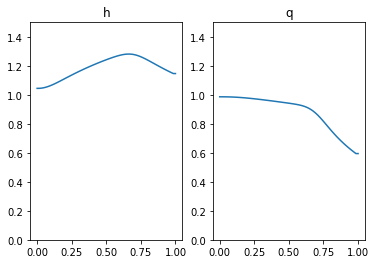

t=0.3506
t=0.3545
t=0.3584


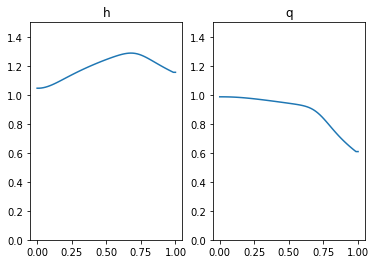

t=0.3623
t=0.3662


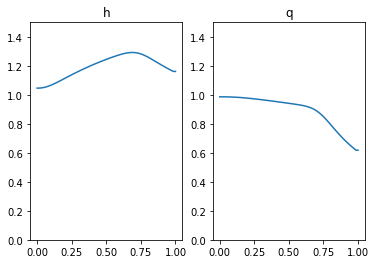

t=0.3701
t=0.374
t=0.378


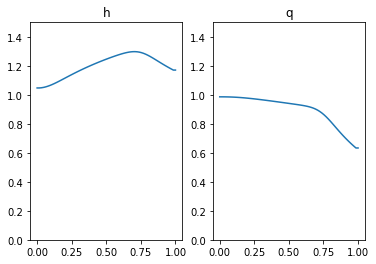

t=0.3819
t=0.3858
t=0.3897


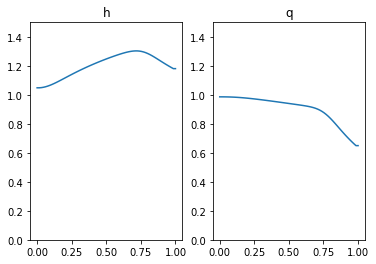

t=0.3936
t=0.3975


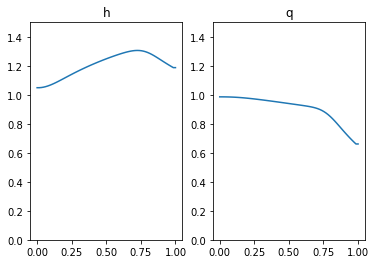

t=0.4014
t=0.4054
t=0.4093


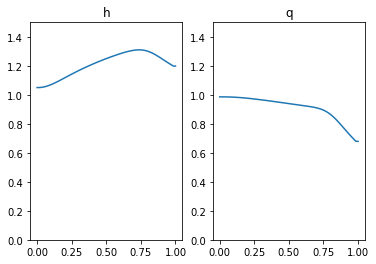

t=0.4132
t=0.4171


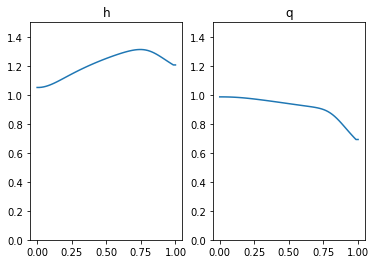

t=0.421
t=0.4249
t=0.4289


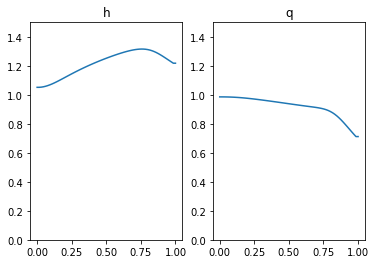

t=0.4328
t=0.4367


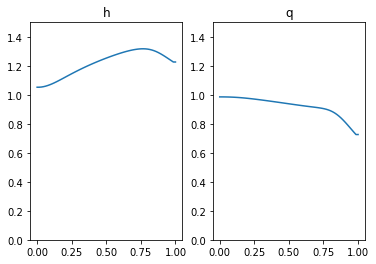

t=0.4406
t=0.4445
t=0.4485


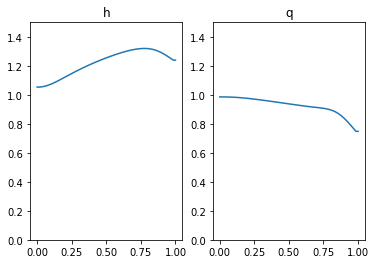

t=0.4524
t=0.4563


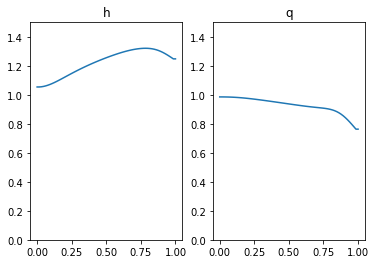

t=0.4602
t=0.4641
t=0.4681


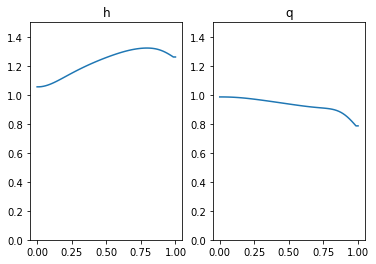

t=0.472
t=0.4759
t=0.4798


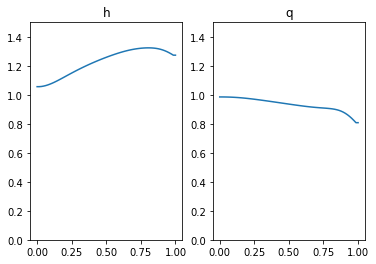

t=0.4838
t=0.4877


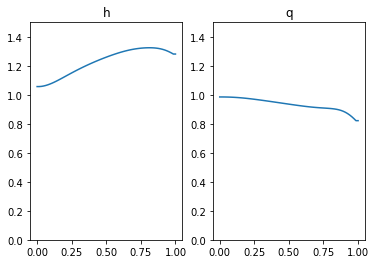

t=0.4916
t=0.4955
t=0.4995


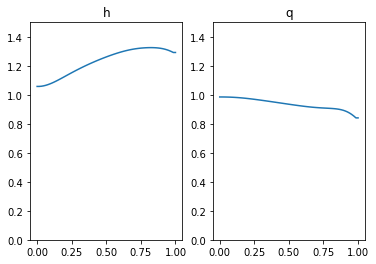

t=0.5034
t=0.5073


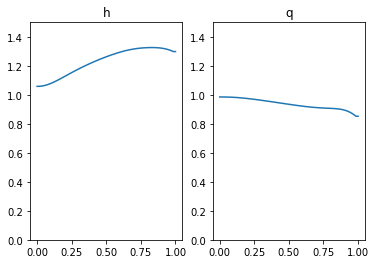

t=0.5112
t=0.5152
t=0.5191


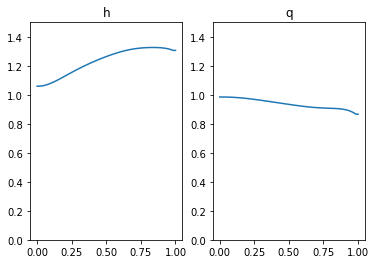

t=0.523
t=0.5269


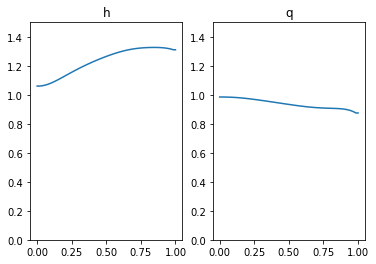

t=0.5309
t=0.5348
t=0.5387


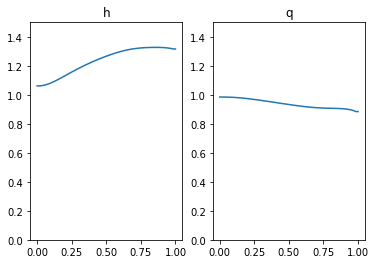

t=0.5426
t=0.5466


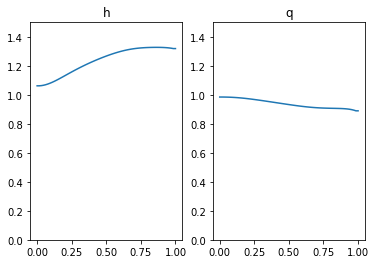

t=0.5505
t=0.5544
t=0.5584


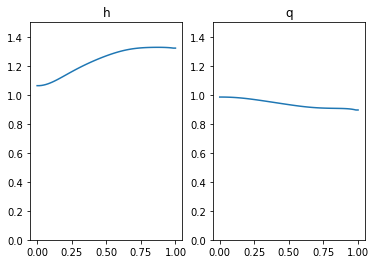

t=0.5623
t=0.5662


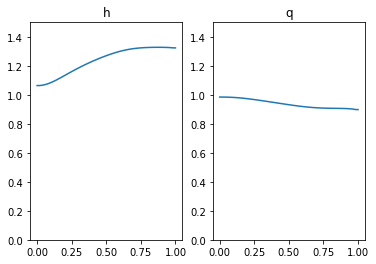

t=0.5701
t=0.5741
t=0.578


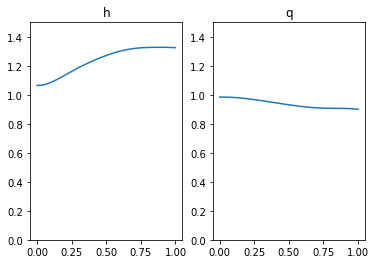

t=0.5819
t=0.5859
t=0.5898


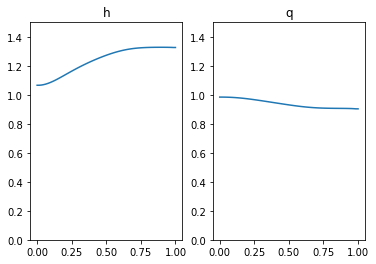

t=0.5937
t=0.5977


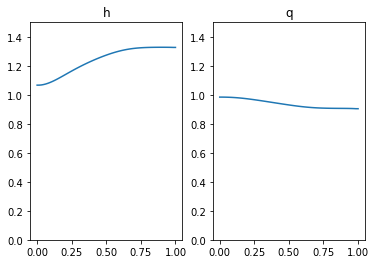

t=0.6016
t=0.6055
t=0.6095


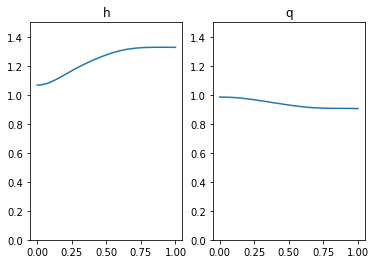

t=0.6134
t=0.6173


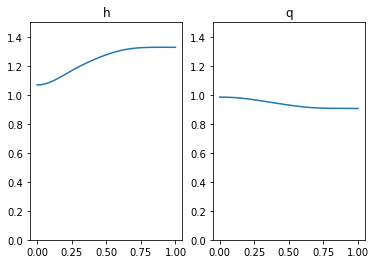

t=0.6213
t=0.6252
t=0.6291


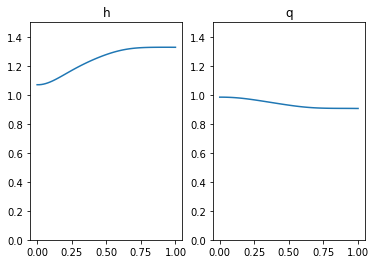

t=0.6331
t=0.637


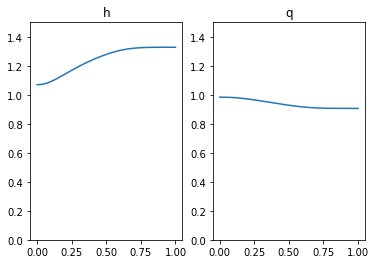

t=0.641
t=0.6449
t=0.6488


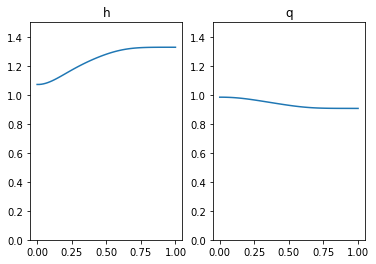

t=0.6528
t=0.6567


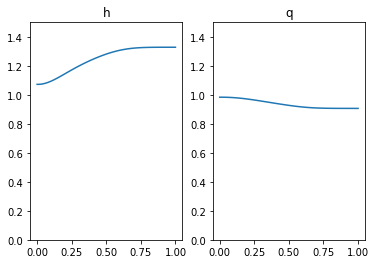

t=0.6606
t=0.6646
t=0.6685


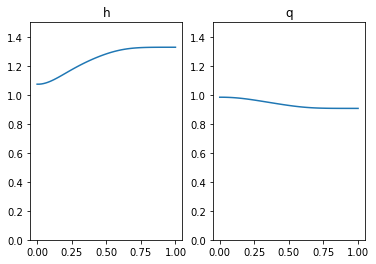

t=0.6725
t=0.6764


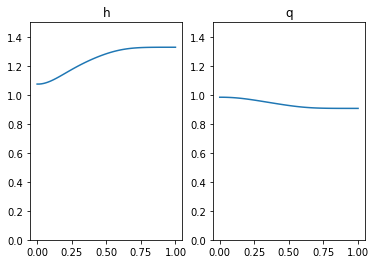

t=0.6803
t=0.6843
t=0.6882


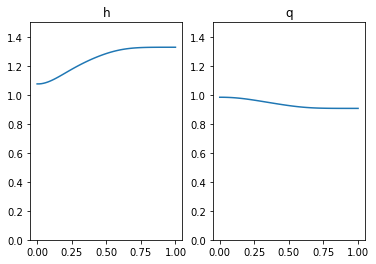

t=0.6922
t=0.6961


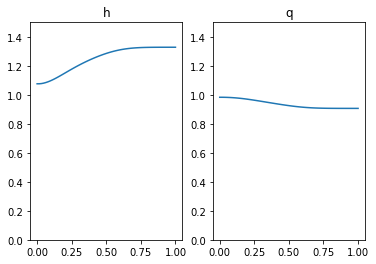

t=0.7
t=0.704
t=0.7079


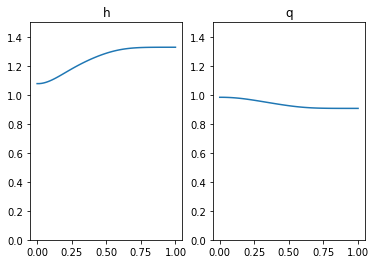

t=0.7119
t=0.7158
t=0.7198


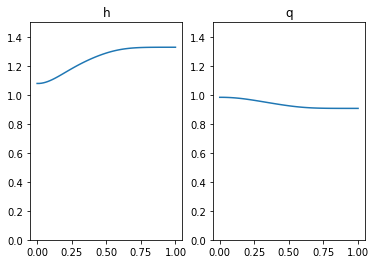

t=0.7237
t=0.7277


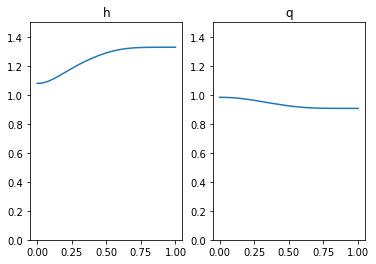

t=0.7316
t=0.7355
t=0.7395


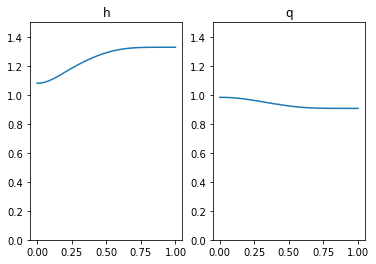

t=0.7434
t=0.7474


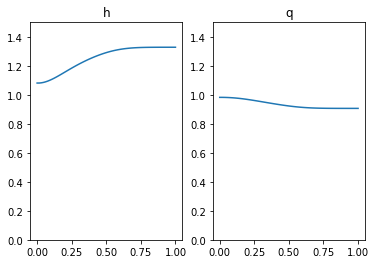

t=0.7513
t=0.7553
t=0.7592


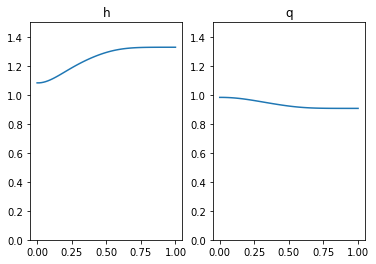

t=0.7632
t=0.7671


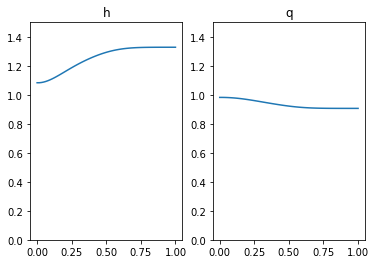

t=0.7711
t=0.775
t=0.779


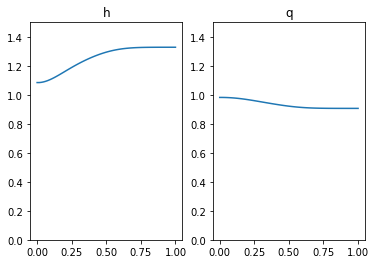

t=0.7829
t=0.7869


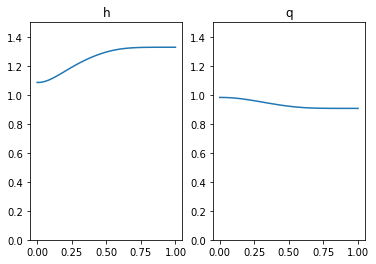

t=0.7908
t=0.7948
t=0.7987


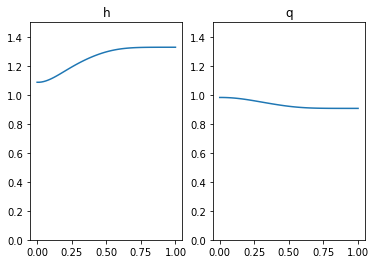

t=0.8027
t=0.8066


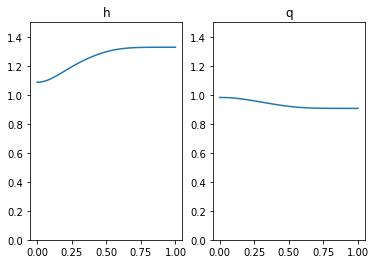

t=0.8106
t=0.8145
t=0.8185


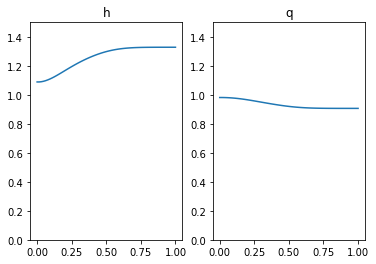

t=0.8225
t=0.8264


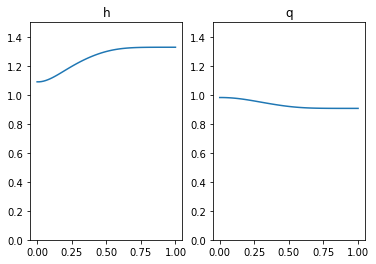

t=0.8304
t=0.8343
t=0.8383


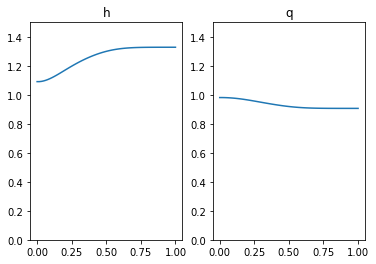

t=0.8422
t=0.8462


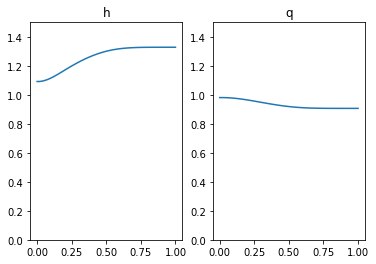

t=0.8501
t=0.8541
t=0.8581


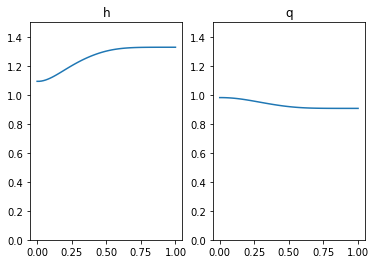

t=0.862
t=0.866
t=0.8699


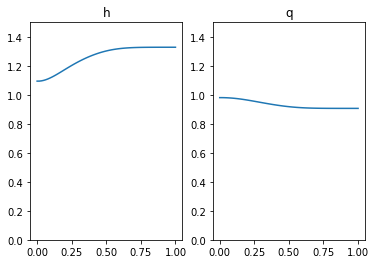

t=0.8739
t=0.8779


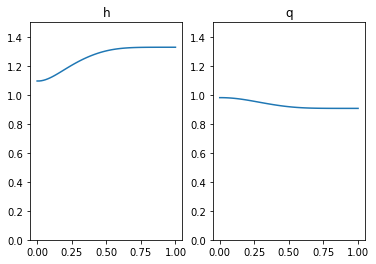

t=0.8818
t=0.8858
t=0.8897


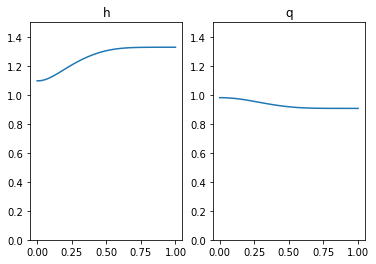

t=0.8937
t=0.8977


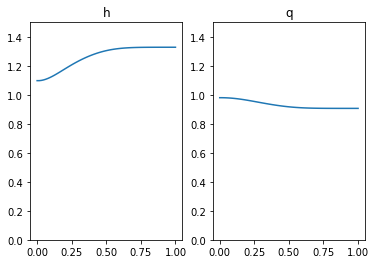

t=0.9016
t=0.9056
t=0.9096


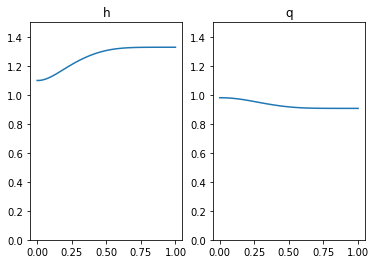

t=0.9135
t=0.9175


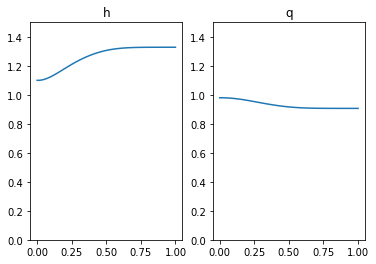

t=0.9215
t=0.9254
t=0.9294


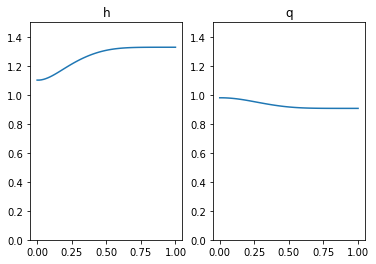

t=0.9334
t=0.9373


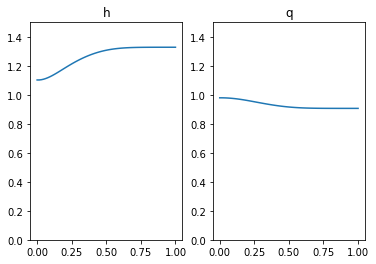

t=0.9413
t=0.9453
t=0.9492


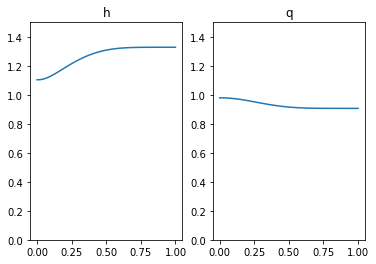

t=0.9532
t=0.9572


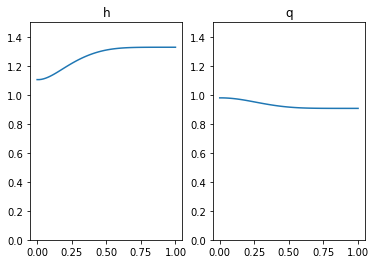

t=0.9611
t=0.9651
t=0.9691


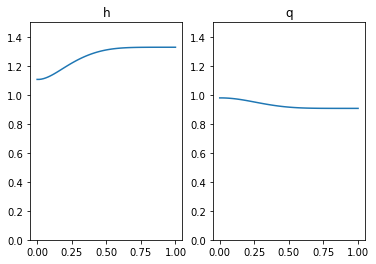

t=0.9731
t=0.977


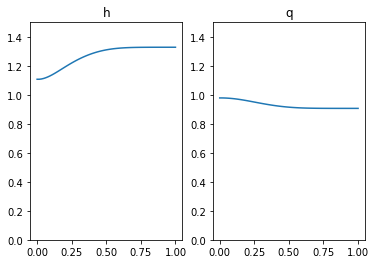

t=0.981
t=0.985
t=0.9889


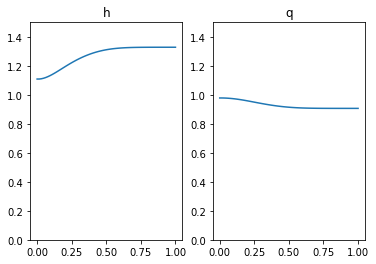

t=0.9929
t=0.9969
Nombre d'itérations : 255


In [13]:
maxListe = [0 for i in range(N+2)] # Liste qui va contenir les conditions de stabilité 

enregistre_U(n,t)

while(t<T): # Tant que le temps max n'est pas atteint :

    print("t="+str(round(t,4)))
    
    # Recherche condition de stabilité
    
    for i in range(1,N+1):
        
        maxListe[i] = abs( U[1,i]/U[0,i] + math.sqrt(g * U[0,i] ) )
        
        if ( abs( U[1,i]/U[0,i] - math.sqrt(g * U[0,i] ) ) > maxListe[i] ):
            maxListe[i] = abs( U[1,i]/U[0,i] - math.sqrt(g * U[0,i] ) )
        
        if ( abs( U[1,i+1]/U[0,i+1] + math.sqrt(g * U[0,i+1] ) ) > maxListe[i] ):
            maxListe[i] = abs( U[1,i+1]/U[0,i+1] + math.sqrt(g * U[0,i+1] ) )
    
        if ( abs( U[1,i+1]/U[0,i+1] - math.sqrt(g * U[0,i+1] ) ) > maxListe[i] ):
            maxListe[i] = abs( U[1,i+1]/U[0,i+1] - math.sqrt(g * U[0,i+1] ) )

    M = max( maxListe )
    
    # Pour assurer la stabilité, tau doit être inférieur à h/(2* max(vp))
    tau = h/(2*M)
    
    for i in range(1,N+1):
        
        F = fonctionF( U , i , tau )
       
        m1 = maxListe[i]
        m2 = maxListe[i-1]
        
        Uprime[0,i] = U[0,i] - F[0] + (tau*m1/(2*h))*(U[0,i+1]-U[0,i]) - (tau*m2/(2*h))*(U[0,i]-U[0,i-1])
        Uprime[1,i] = U[1,i] - F[1] + (tau*m1/(2*h))*(U[1,i+1]-U[1,i]) - (tau*m2/(2*h))*(U[1,i]-U[1,i-1])

    for i in range(1,N+1):
        U[0,i] = Uprime[0,i]
        U[1,i] = Uprime[1,i]
    
        Uprime[0,i] = 0
        Uprime[1,i] = 0
    
    # Conditions aux bords
    U[0,0] = U[0,1]
    U[1,0] = U[1,1]
    U[0,N+1] = U[0,N]
    U[1,N+1] = U[1,N]

    t+=tau
    n+=1
    
    if (t > T/nSauvegarde*j and (j<nSauvegarde) and (not tSauvegarde[j])):
        #enregistre_U(n,t)
        affiche_U()
        tSauvegarde[j]=True
        j+=1

print("Nombre d'itérations : " + str(n))